# Create small files which can fit in PizzaBox <a class="tocSkip">
Looking at the size of the examples used in the LynxKite tutotials, we would like to randomly choose around 500,000 transactions, which correspond to 1,5%.

In [1]:
import random
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

random.seed(1)

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
df_train = pd.read_csv("input/train.csv")
df_train = reduce_mem_usage(df_train)
df_test = pd.read_csv("input/test.csv")
df_test = reduce_mem_usage(df_test)
df_hist_trans = pd.read_csv("input/historical_transactions.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.7% reduction)
Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)


In [15]:
ids_train = df_train['card_id'].unique()
ids_train = ids_train[np.random.uniform(0,1,ids_train.shape[0])<0.015]
print("Selected {:.2f}% of train cards".format(ids_train.size/df_train['card_id'].nunique()*100))

Selected 1.55% of train cards


In [16]:
ids_test = df_test['card_id'].unique()
ids_test = ids_test[np.random.uniform(0,1,ids_test.shape[0])<0.015]
print("Selected {:.2f}% of test cards".format(ids_test.size/df_test['card_id'].nunique()*100))

Selected 1.44% of test cards


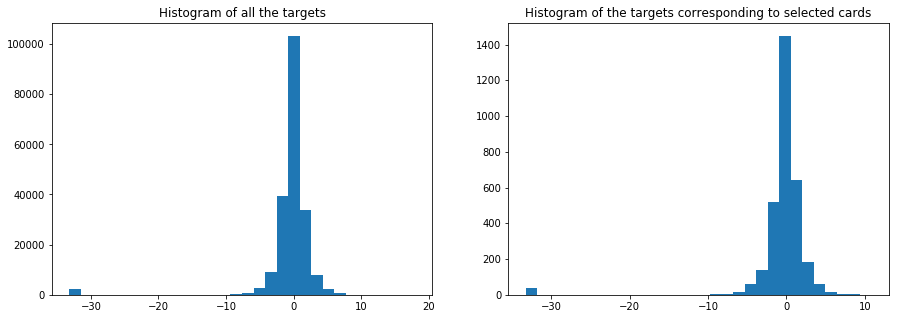

In [24]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Histogram of all the targets')
plt.hist(df_train['target'].values, bins=30)
plt.subplot(1, 2, 2)
plt.title('Histogram of the targets corresponding to selected cards')
plt.hist(df_train[df_train['card_id'].isin(ids_train)]['target'].values, bins=30)
plt.show()

We see that the distribution of the targets is rather similar, so the selected cards may be a representative sample of the total.

In [28]:
df_trans = pd.concat([df_hist_trans, df_new_trans])
df_trans_PB = df_trans[df_trans['card_id'].isin(np.concatenate((ids_train,ids_test)))].reset_index()
print("Selected {:.2f}% of transactions".format(df_trans_PB.shape[0]/df_trans.shape[0]*100))

Selected 1.49% of transactions


The only thing remaining is to select the merchants that appear among the selected transactions.

In [2]:
df_merch = pd.read_csv("input/merchants.csv")
df_merch = reduce_mem_usage(df_merch)

Starting memory usage: 56.18 MB
Reduced memory usage: 30.32 MB (46.0% reduction)


In [32]:
df_merch_PB = df_merch[df_merch['merchant_id'].isin(df_trans_PB['merchant_id'].unique())]
print("Selected {:.2f}% of the merchants".format(df_merch_PB.shape[0]/df_merch.shape[0]*100))

Selected 23.05% of the merchants


As expected, this reduction won't be to 1,5% of the merchants. We create a new column in the transactions DataFrame to store the purchase_date as a TimeStamp (in order to be able to work with it in PizzaBox) and then the reduced data sets are stored into csv files.

In [42]:
df_trans_PB['purchase_date_unix'] = pd.to_datetime(df_trans_PB['purchase_date']).apply(lambda t: datetime.timestamp(t))
df_train[df_train['card_id'].isin(ids_train)].to_csv("output/train_PB.csv", index=False)
df_test[df_test['card_id'].isin(ids_test)].to_csv("output/test_PB.csv", index=False)
df_trans_PB.to_csv("output/trans_PB.csv", index=False)
df_merch_PB.to_csv("output/merch_PB.csv", index=False)

In [28]:
#df_trans_PB.head(1).to_csv("output/trans_PB_1row.csv", index=False)